In [12]:
import gradio as gr
import tensorflow as tf
import numpy as np
import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

Num GPUs Available: 1
Total images: 26179
Classes found: 10


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,921,034 (11.14 MB)

 Trainable params: 662,026 (2.53 MB)

 Non-trainable params: 2,259,008 (8.62 MB)


🚀 Starting ARMORED training session...
Epoch 1/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7698 - loss: 0.8087
Epoch 1: val_accuracy improved from None to 0.94843, saving model to best_model.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.8183 - loss: 0.6212 - val_accuracy: 0.9484 - val_loss: 0.1714 - learning_rate: 0.0010
Epoch 2/15
368/369 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8460 - loss: 0.4837
Epoch 2: val_accuracy improved from 0.94843 to 0.95302, saving model to best_model.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.8489 - loss: 0.4713 - val_accuracy: 0.9530 - val_loss: 0.1748 - learning_rate: 0.0010
Epoch 3/15
368/369 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8591 - loss: 0.4413
Epoch 3: val_accuracy did not improve from 0.95302

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.8614 - loss: 0.4313 - val_accuracy: 0.9465 - val_los

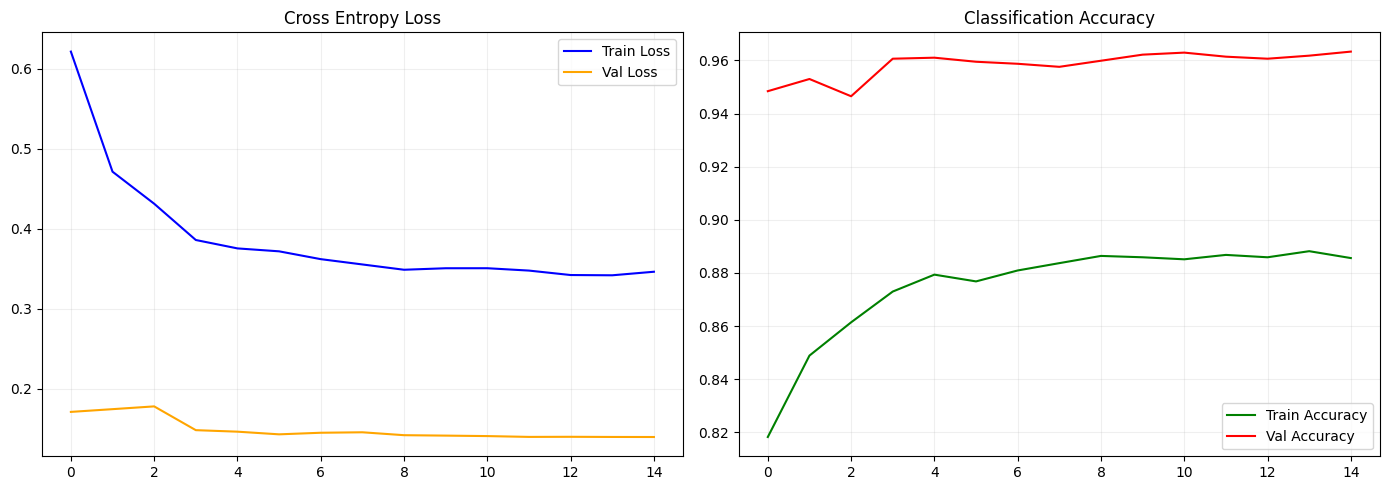


--- Sample Predictions (Batch of 6) ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


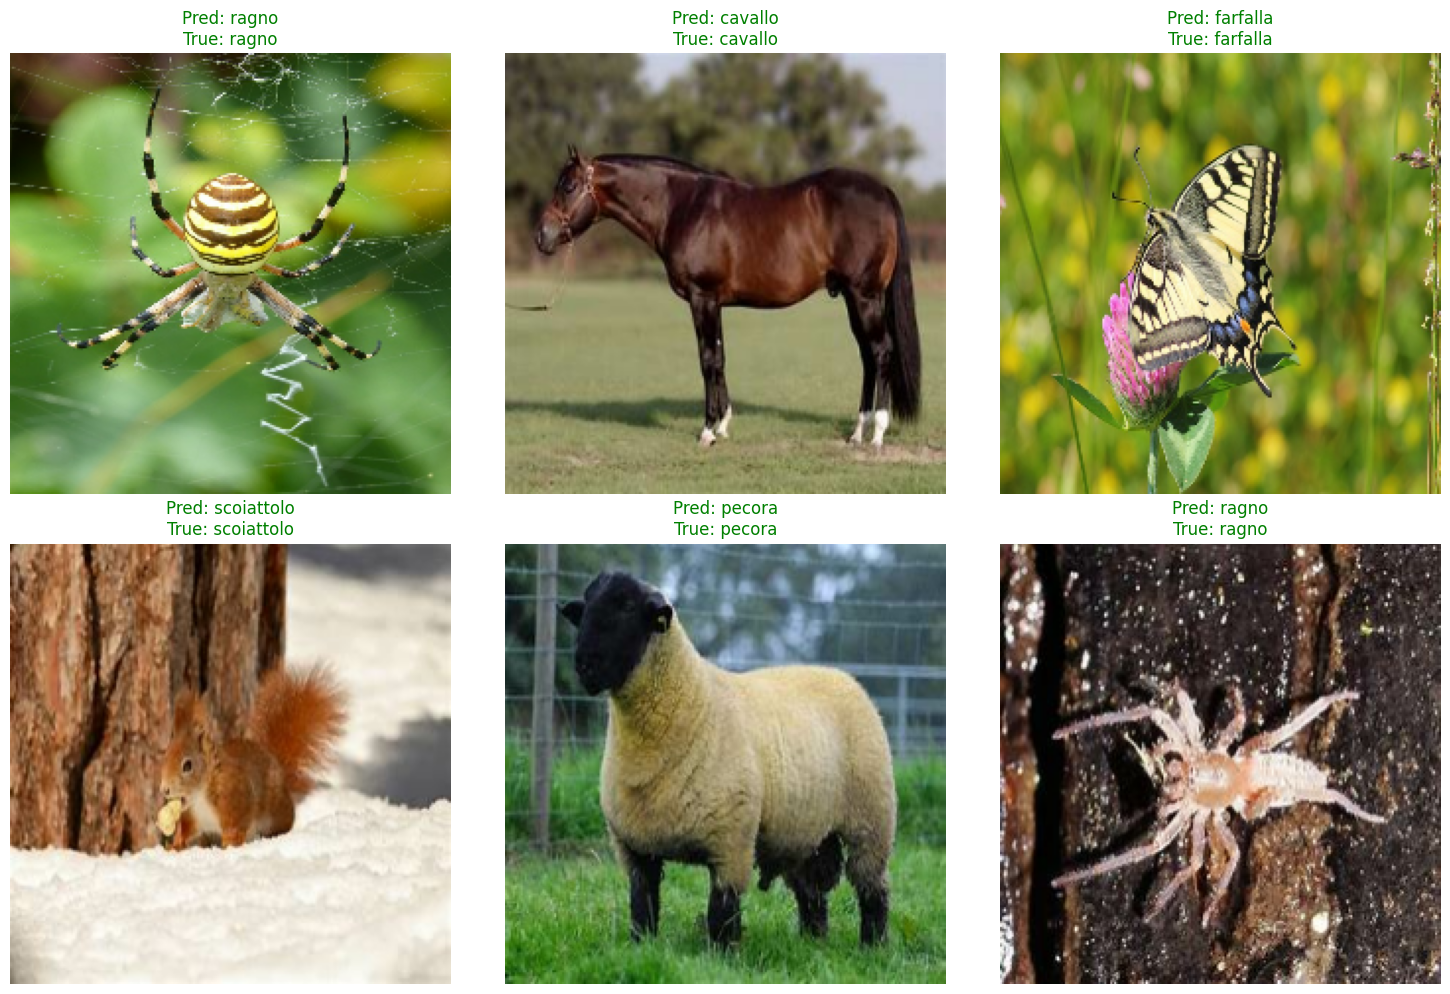

SyntaxError: 'break' outside loop (3797815778.py, line 221)

In [ ]:
import os
import logging
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from PIL import Image

# -----------------------------
# 0️⃣ SYSTEM CONFIGURATION (SILENCE & GPU)
# -----------------------------
# Silence system logs and C++ warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

# Constants
DATASET_PATH = r"/Users/ia_dev/Desktop/Work/archive/raw-img" # Verify your path
IMG_SIZE = 224
BATCH_SIZE = 64 # Optimized for M4 Max
EPOCHS = 15
RANDOM_SEED = 42

print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# -----------------------------
# 1️⃣ DATA PREPARATION & METADATA
# -----------------------------
data = []

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Path {DATASET_PATH} does not exist. Check your path.")

for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        label = folder
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder_path, file)
                data.append([img_path, label])

df = pd.DataFrame(data, columns=["image_path", "label"])

# Label mapping
class_names = sorted(df['label'].unique())
label_map = {name: i for i, name in enumerate(class_names)}
inv_label_map = {i: name for name, i in label_map.items()}
df['label_code'] = df['label'].map(label_map)

print(f"Total images: {len(df)}")
print(f"Classes found: {len(class_names)}")

# -----------------------------
# 2️⃣ TRAIN / TEST SPLIT
# -----------------------------
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df['label'], 
    random_state=RANDOM_SEED
)

# -----------------------------
# 3️⃣ DATASET PIPELINE (tf.data)
# -----------------------------
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    paths = dataframe['image_path'].values
    labels = dataframe['label_code'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def process_path(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        return img, label
    
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
   
    if shuffle:
        ds = ds.shuffle(buffer_size=1024)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Create datasets
train_dataset = df_to_dataset(train_df, batch_size=BATCH_SIZE)
test_dataset = df_to_dataset(test_df, shuffle=False, batch_size=BATCH_SIZE)

# -----------------------------
# 4️⃣ MODEL ARCHITECTURE (MobileNetV2)
# -----------------------------
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, 
    weights='imagenet'
)
base_model.trainable = False # Freeze base model (Transfer Learning)

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,
    # Specific normalization for MobileNetV2 [-1, 1]
    layers.Rescaling(scale=1./127.5, offset=-1.0),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -----------------------------
# 5️⃣ CALLBACKS & TRAINING
# -----------------------------
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   
    patience=2, 
    min_lr=1e-6,  
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,         
    restore_best_weights=True  
)

callbacks = [checkpoint, reduce_lr, early_stopping]

print("\n🚀 Starting ARMORED training session...")
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# -----------------------------
# 6️⃣ EVALUATION & VISUALIZATION
# -----------------------------
print("\n📊 Evaluating Final Model...")
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Validation accuracy: {test_acc:.4f}')

# 1. Plot Training History 
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Cross Entropy Loss')
plt.legend()
plt.grid(True, alpha=0.2)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Classification Accuracy')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# 2. Visualize Predictions (Grid 2x3) 
print("\n--- Sample Predictions (Batch of 6) ---")
plt.figure(figsize=(15, 10)) 

for images, labels in test_dataset.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    for i in range(6): # Loop showing 6 images
        ax = plt.subplot(2, 3, i + 1)
        
        # Process image
        img = images[i].numpy().astype("uint8")
        true_code = labels[i].numpy()
        pred_code = pred_classes[i]
        
        true_label = inv_label_map[true_code]
        pred_label = inv_label_map[pred_code]
        
        # Logic: Green title if Correct, Red if Wrong
        title_color = 'green' if true_code == pred_code else 'red'
        
        plt.imshow(img)
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=title_color, fontsize=12)
        plt.axis('off')

plt.tight_layout()
plt.show()




📊 Generating Confusion Matrix...


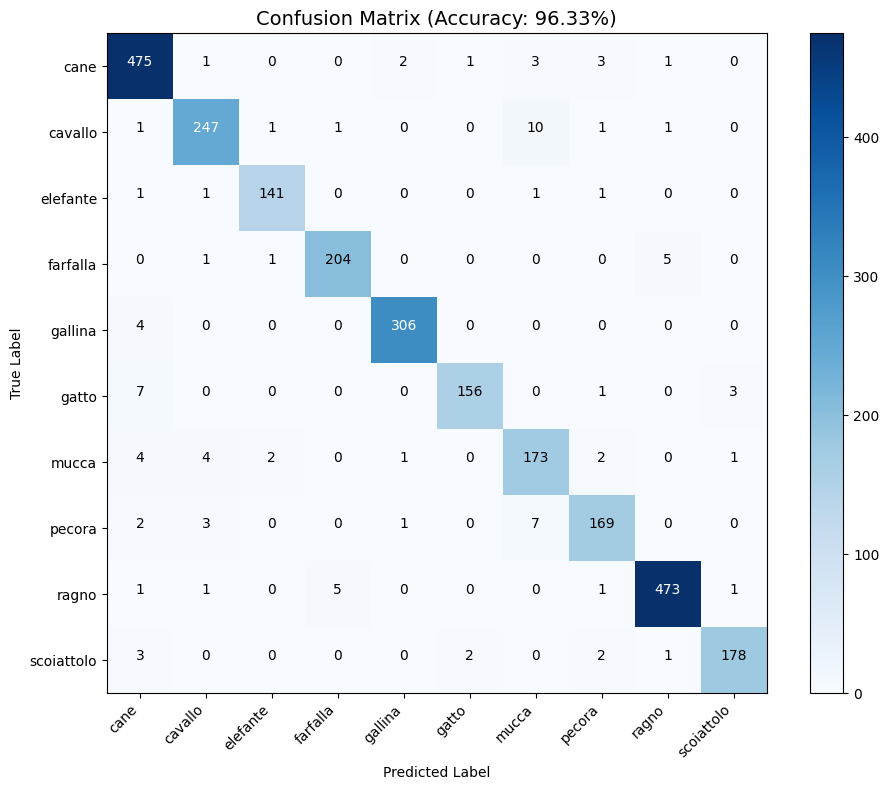

In [6]:
# -----------------------------
# 7️⃣ CONFUSION MATRIX
# -----------------------------
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

print("\n📊 Generating Confusion Matrix...")

# 1. Get all predictions and true labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Visualization (Matplotlib Style)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix (Accuracy: {test_acc:.2%})', fontsize=14)
plt.colorbar()

# Set labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

# Add numbers inside the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


🚀 Starting Batch Inference Module...
🔍 Analyzing 7 images...


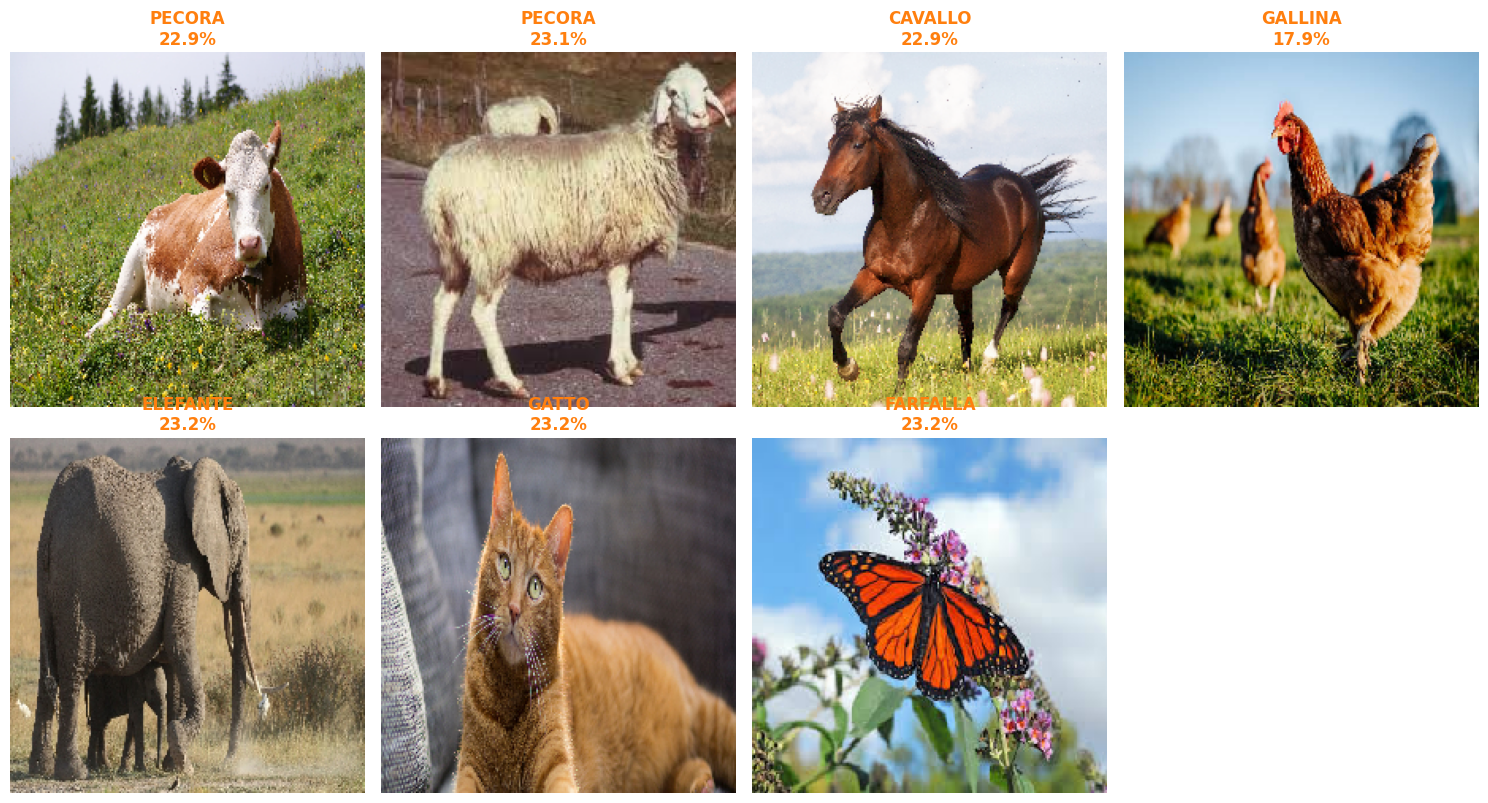

In [10]:
# -----------------------------
# 8️⃣ BATCH TESTING (FOLDER MODE)
# -----------------------------
import os
import math

print("\n🚀 Starting Batch Inference Module...")

def predict_folder(folder_path):
    # 1. Validation
    if not os.path.exists(folder_path):
        print(f"❌ Folder not found: {folder_path}")
        return

    # 2. Get Images (Filter mac junk)
    valid_exts = ('.jpg', '.jpeg', '.png')
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]
    
    if not files:
        print("⚠️ No images found.")
        return

    # 3. Setup Grid (Auto-adjust rows)
    limit = 12 # Max images to show
    files = files[:limit]
    cols = 4
    rows = math.ceil(len(files) / cols)
    
    print(f"🔍 Analyzing {len(files)} images...")
    plt.figure(figsize=(15, 4 * rows))

    # 4. Loop & Predict
    for i, filename in enumerate(files):
        try:
            # Load & Preprocess
            img_path = os.path.join(folder_path, filename)
            img = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img_arr = tf.expand_dims(tf.keras.utils.img_to_array(img), 0)

            # Inference
            preds = model.predict(img_arr, verbose=0)
            score = tf.nn.softmax(preds[0])
            
            # Decode
            label = class_names[np.argmax(preds[0])]
            conf = 100 * np.max(score)

            # Plot
            ax = plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            
            # Color Logic: Green (>85%) / Orange (<85%)
            color = 'green' if conf > 85 else 'tab:orange'
            plt.title(f"{label.upper()}\n{conf:.1f}%", color=color, fontweight='bold')
            plt.axis('off')
            
        except Exception as e:
            print(f"⚠️ Error on {filename}: {e}")

    plt.tight_layout()
    plt.show()

# Run
test_folder = r"/Users/ia_dev/Desktop/Project Folder/Project 1 (G2) Deep Learning-Image Classification with CNN/Test photos" 

predict_folder(test_folder)

In [ ]:
# -----------------------------
# 7️⃣ GRADIO
# -----------------------------

# 1. Define the prediction function
def predict_image(img):
    # Ensure image is a numpy array
    img_array = np.array(img)
    
    # Preprocess the image to match model input (224x224)
    # This replaces the 'shape' argument from the old Gradio versions
    img_resized = tf.image.resize(img_array, (224, 224))
    img_batch = tf.expand_dims(img_resized, 0) # Add batch dimension
    
    # Run inference
    predictions = model.predict(img_batch)
    
    # Map predictions to class names
    # Ensure class_names is defined in your notebook (e.g., from train_ds.class_names)
    return {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}

# 2. Configure the Gradio Interface
# Removed the 'shape' keyword argument to fix the TypeError
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(), 
    outputs=gr.Label(num_top_classes=3),
    title="Image Classification Inference"
)

# 3. Launch the app
interface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/Users/ia_dev/Downloads/yes/envs/ia-audio/lib/python3.10/site-packages/gradio/queueing.py", line 766, in process_events
    response = await route_utils.call_process_api(
  File "/Users/ia_dev/Downloads/yes/envs/ia-audio/lib/python3.10/site-packages/gradio/route_utils.py", line 355, in call_process_api
    output = await app.get_blocks().process_api(
  File "/Users/ia_dev/Downloads/yes/envs/ia-audio/lib/python3.10/site-packages/gradio/blocks.py", line 2152, in process_api
    result = await self.call_function(
  File "/Users/ia_dev/Downloads/yes/envs/ia-audio/lib/python3.10/site-packages/gradio/blocks.py", line 1629, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/Users/ia_dev/Downloads/yes/envs/ia-audio/lib/python3.10/site-packages/anyio/to_thread.py", line 63, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "/Users/ia_dev/Downloads/yes/envs/ia-audio/lib/python3.10/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
